In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [3]:
sns.set()

# Import data

In [4]:
DATASET_PATH = '/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/data/income_per_day.csv'
df_raw = pd.read_csv(DATASET_PATH)

In [5]:
def feature_engineering(DF):
    for lag in range(1,5, 2):
        DF[f'Lag{lag}'] = DF['income'].shift(lag)
    DF['RollingMean'] = DF['income'].rolling(window=3).mean()
    DF.dropna(inplace=True)

    # Convert Date to numeric features
    DF['date'] = pd.to_datetime(DF['date'])
    DF['Year'] = DF['date'].dt.year
    DF['Month'] = DF['date'].dt.month
    DF['Day'] = DF['date'].dt.day
    DF.set_index('date', inplace=True)

    return DF

In [6]:
df = feature_engineering(df_raw)

In [7]:
def split_processed_data(DF):
        X_train, X_test, y_train, y_test = train_test_split(
                DF.drop(columns='income'),
                DF[['income']],
                test_size = 0.2, 
                random_state = 42,
                shuffle=False)
        return X_train, X_test, y_train, y_test 


In [8]:
X_train, X_test, y_train, y_test  = split_processed_data(df)

In [35]:
# Function to create pipelines
def create_pipeline(model):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    return pipeline

# Function to train and evaluate models
def set_train_and_evaluation(model, X_train, y_train, X_test, y_test):
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse

def get_best_model(models):
    results = {}
    # Train and evaluate each model
    for name, model in models.items():
        results[name] = set_train_and_evaluation(
            model, 
            X_train, 
            y_train,
            X_test, 
            y_test)
        
    best_model_df = (pd.DataFrame(results.items())
                  .rename(columns={0:'model', 1:'mse'})
                  .sort_values('mse', ascending=True)
                  .head(1)
                  )
    print(best_model_df)
    return best_model_df['model'].values[0]

# List of models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'CatBoost': CatBoostRegressor(verbose=False),
    'LightGBM': LGBMRegressor()
}
best_model = get_best_model(models)


/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 241, number of used features: 5
[LightGBM] [Info] Start training from score 111874713.414419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
# Here I just use Linear Regression params, I could be necessary to 
# implement optimizations for other models

def get_best_params(X_train, y_train, best_model):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', models[best_model])
    ])
    pipeline = pipeline.fit(X_train, y_train)

    # Define the parameter grid for grid search specific to LinearRegression
    param_grid = {
        'model__fit_intercept': [True, False],
        'model__copy_X': [True, False]  # Prefix with 'model__' since it's inside the pipeline
    }

    # Set up the grid search with TimeSeriesSplit for time series data
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error')

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print("Best Parameters: ", best_params)
    print("Best Score: ", grid_search.best_score_)

    return best_params

best_params = get_best_params(X_train, y_train, best_model)
print(best_params)
# Predict with the best model
#y_pred = best_model.predict(X_test)


Best Parameters:  {'model__copy_X': True, 'model__fit_intercept': True}
Best Score:  -5839688363901248.0
{'model__copy_X': True, 'model__fit_intercept': True}


In [46]:
def full_featured_data(DF):
    X = DF[['Lag1', 'Lag3', 'RollingMean', 'Year', 'Month', 'Day']]
    y = DF['income']
    return X, y

def train_final_model(X, y):
    # Create and train the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression(fit_intercept=True, copy_X=True))
    ])
    return pipeline.fit(X, y)

X, y = full_featured_data(df)
final_model = train_final_model(X, y)

In [14]:
# Generate the next 14 days
last_date = df.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=14)

# Prepare the future DataFrame with lags and rolling mean
future_df = pd.DataFrame({'date': future_dates})
future_df['Year'] = future_df['date'].dt.year
future_df['Month'] = future_df['date'].dt.month
future_df['Day'] = future_df['date'].dt.day

# Use the last available lags and rolling mean for prediction
last_row = df.iloc[-1]
for lag in range(1,5,2):
    future_df[f'Lag{lag}'] = last_row[f'Lag{lag}']
future_df['RollingMean'] = last_row['RollingMean']

         date  Predicted_Income
0  2011-12-10      2.405497e+08
1  2011-12-11      5.707701e+08
2  2011-12-12      5.068085e+08
3  2011-12-13      3.790625e+08
4  2011-12-14      4.835317e+08
5  2011-12-15      5.043799e+08
6  2011-12-16      4.479566e+08
7  2011-12-17      4.721625e+08
8  2011-12-18      4.951097e+08
9  2011-12-19      4.770529e+08
10 2011-12-20      4.795432e+08
11 2011-12-21      4.921878e+08
12 2011-12-22      4.887680e+08
13 2011-12-23      4.876369e+08


/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/py

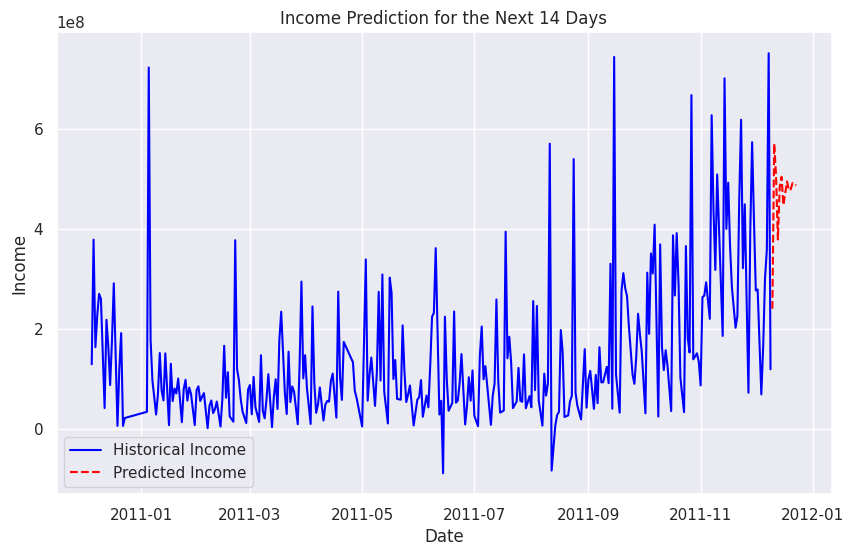

In [15]:
# Generate the next 14 days
last_date = df.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=14)

# Prepare the future DataFrame with lags and rolling mean
future_df = pd.DataFrame({'date': future_dates})
future_df['Year'] = future_df['date'].dt.year
future_df['Month'] = future_df['date'].dt.month
future_df['Day'] = future_df['date'].dt.day

# Initialize an empty list to store future predictions
future_predictions = []

# Use the last available lags and rolling mean for prediction
for i in range(14):
    if i == 0:
        future_df.loc[i, 'Lag1'] = df.iloc[-2]['income']
        future_df.loc[i, 'Lag3'] = df.iloc[-4]['income']
        future_df.loc[i, 'RollingMean'] = df.iloc[-3:]['income'].mean()
    else:
        future_df.loc[i, 'Lag0'] = future_predictions[-1]
        future_df.loc[i, 'Lag1'] = future_predictions[-2] if i > 1 else df.iloc[-1]['income']
        future_df.loc[i, 'Lag2'] = future_predictions[-3] if i > 2 else df.iloc[-2]['income']
        future_df.loc[i, 'Lag3'] = future_predictions[-4] if i > 3 else df.iloc[-3]['income']
        future_df.loc[i, 'RollingMean'] = np.mean(future_predictions[-3:]) if i >= 3 else df.iloc[-3:]['income'].mean()

    # Prepare features for the current prediction
    X_future = future_df.loc[i, ['Lag1', 'Lag3', 'RollingMean', 'Year', 'Month', 'Day']].values.reshape(1, -1)

    # Predict income and store it
    predicted_value = pipeline.predict(X_future)[0]
    future_predictions.append(predicted_value)

# Add predictions to future_df
future_df['Predicted_Income'] = future_predictions

# Print the predicted values
print(future_df[['date', 'Predicted_Income']])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['income'], label='Historical Income', color='blue')
plt.plot(future_df['date'], future_df['Predicted_Income'], label='Predicted Income', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Income')
plt.title('Income Prediction for the Next 14 Days')
plt.legend()
plt.show()